In [1]:
import os
from mcnptools import Mctal, MctalTally
import INS_Denoiser as insd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import seaborn as sns

In [3]:
trials_file = 'input/input_generation/filenames.csv'
trials = pd.read_csv(trials_file)
trials

name  x_pos      z_pos  distance_from_shielding  \
0    detector_x_40_z_-7   40.0  -7.000000                      0.0   
1    detector_x_40_z_-3   40.0  -3.666667                      0.0   
2     detector_x_40_z_0   40.0  -0.333333                      0.0   
3     detector_x_40_z_3   40.0   3.000000                      0.0   
4     detector_x_40_z_6   40.0   6.333333                      0.0   
..                  ...    ...        ...                      ...   
85    detector_x_70_z_0   70.0  -0.333333                     30.0   
86    detector_x_70_z_3   70.0   3.000000                     30.0   
87  detector_x_80_z_-17   80.0 -17.000000                     40.0   
88   detector_x_80_z_-2   80.0  -2.000000                     40.0   
89   detector_x_80_z_13   80.0  13.000000                     40.0   

    distance_from_ground  
0              30.000000  
1              33.333333  
2              36.666667  
3              40.000000  
4              43.333333  
..                   ...  
85             36.666667  
86             40.000000  
87             20.000000  
88             35.000000  
89             50.000000  

[90 rows x 5 columns]

In [4]:
file_prefix = 'output/mctal/'
file_type = '.mctal'
# check if the file exists
filenames = []
for index, row in trials.iterrows():
    filename = file_prefix + row['name'] + file_type
    # check if the file exists

    if os.path.isfile(filename):
        filenames.append(row['name'])
filenames

trials = trials[trials['name'].isin([os.path.basename(f) for f in filenames])]
trials['filename'] = file_prefix + trials['name'] + file_type
trials = trials.reset_index(drop=True)

# first_n = 10
# trials = trials.head(first_n)
filenames = trials['filename'].tolist()
trials

name  x_pos      z_pos  distance_from_shielding  \
0    detector_x_40_z_-7   40.0  -7.000000                      0.0   
1    detector_x_40_z_-3   40.0  -3.666667                      0.0   
2     detector_x_40_z_0   40.0  -0.333333                      0.0   
3     detector_x_40_z_3   40.0   3.000000                      0.0   
4     detector_x_40_z_6   40.0   6.333333                      0.0   
..                  ...    ...        ...                      ...   
85    detector_x_70_z_0   70.0  -0.333333                     30.0   
86    detector_x_70_z_3   70.0   3.000000                     30.0   
87  detector_x_80_z_-17   80.0 -17.000000                     40.0   
88   detector_x_80_z_-2   80.0  -2.000000                     40.0   
89   detector_x_80_z_13   80.0  13.000000                     40.0   

    distance_from_ground                                filename  
0              30.000000   output/mctal/detector_x_40_z_-7.mctal  
1              33.333333   output/mctal/detector_x_40_z_-3.mctal  
2              36.666667    output/mctal/detector_x_40_z_0.mctal  
3              40.000000    output/mctal/detector_x_40_z_3.mctal  
4              43.333333    output/mctal/detector_x_40_z_6.mctal  
..                   ...                                     ...  
85             36.666667    output/mctal/detector_x_70_z_0.mctal  
86             40.000000    output/mctal/detector_x_70_z_3.mctal  
87             20.000000  output/mctal/detector_x_80_z_-17.mctal  
88             35.000000   output/mctal/detector_x_80_z_-2.mctal  
89             50.000000   output/mctal/detector_x_80_z_13.mctal  

[90 rows x 6 columns]

In [5]:
# tallies 18-88 (ending with 8) are the flux tallies

In [6]:
# repeat the process for all the files
spectrograms = []
bins = None

for filename in filenames: # multi thread this maybe?
    bins, vals = insd.tools.mcnp_Reader.get_spectrogram(filename, tally=38, start_time_bin=0, end_time_bin=150, nps=1e8)
    spectrograms.append(np.array(vals))

spectrograms = np.array(spectrograms)
bins = np.array(bins)

names = trials['name'].tolist()

spectrograms.shape

(90, 150, 935)

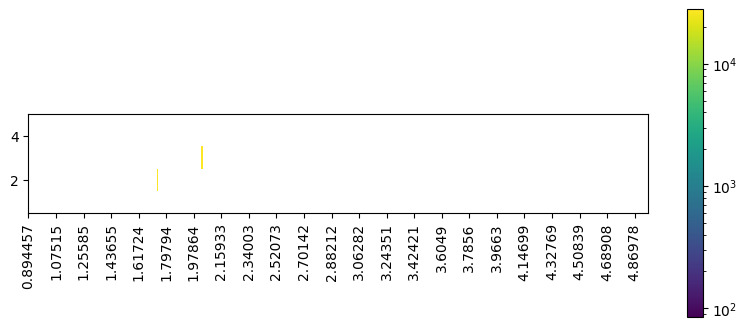

In [7]:

tempvals = spectrograms[0].copy()
# tempvals[tempvals == 0] = np.nan

norm = colors.LogNorm(tempvals.mean() + 0.5 * tempvals.std(), tempvals.max(), clip='True')
tempvals[tempvals == 0] = np.nan
plt.figure(figsize=(10, 4))
ax = plt.imshow(
    tempvals, 
    # cmap=cm.gray, 
    aspect=16,
    norm=norm, 
    origin="lower",
    interpolation='none'
    )
plt.ylim(.5, 5)

# replace the x-axis with energy bins
ticks = np.arange(len(bins))

plt.xticks(ticks[::20], bins[::20], rotation=90)
plt.xlim(100, 550)
plt.colorbar(ax)
plt.show()

In [8]:
sums = np.sum(spectrograms, axis=(1, 2))
trials['activity'] = sums

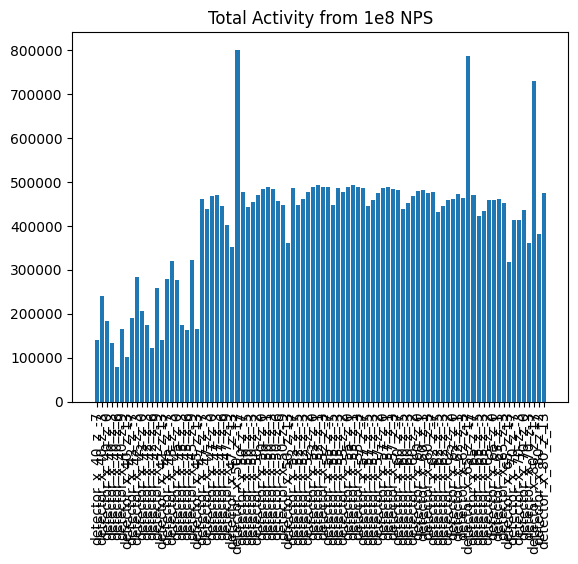

In [9]:
# compare sum of all the bins for each of the files
sums = np.sum(spectrograms, axis=(1, 2))
plt.bar(range(len(sums)), sums)
plt.xticks(range(len(sums)), names, rotation=90)
plt.title('Total Activity from 1e8 NPS')
plt.show()

In [10]:
trials.head()

name  x_pos     z_pos  distance_from_shielding  \
0  detector_x_40_z_-7   40.0 -7.000000                      0.0   
1  detector_x_40_z_-3   40.0 -3.666667                      0.0   
2   detector_x_40_z_0   40.0 -0.333333                      0.0   
3   detector_x_40_z_3   40.0  3.000000                      0.0   
4   detector_x_40_z_6   40.0  6.333333                      0.0   

   distance_from_ground                               filename  activity  
0             30.000000  output/mctal/detector_x_40_z_-7.mctal  139509.0  
1             33.333333  output/mctal/detector_x_40_z_-3.mctal  240000.0  
2             36.666667   output/mctal/detector_x_40_z_0.mctal  182982.4  
3             40.000000   output/mctal/detector_x_40_z_3.mctal  133333.2  
4             43.333333   output/mctal/detector_x_40_z_6.mctal   80000.0

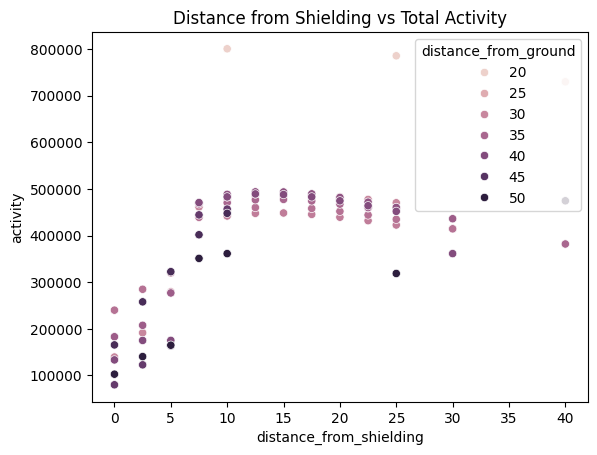

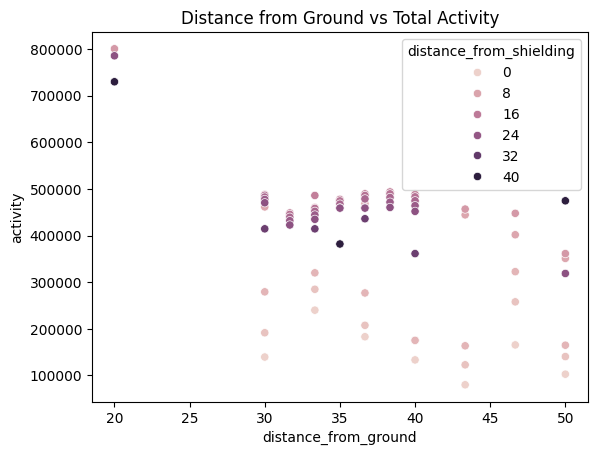

In [11]:

# now in seaborn
plt.figure()
sns.scatterplot(x='distance_from_shielding', y='activity', data=trials, hue='distance_from_ground')
plt.title('Distance from Shielding vs Total Activity')
plt.show()

plt.figure()
sns.scatterplot(x='distance_from_ground', y='activity', data=trials, hue='distance_from_shielding')
plt.title('Distance from Ground vs Total Activity')
plt.show()

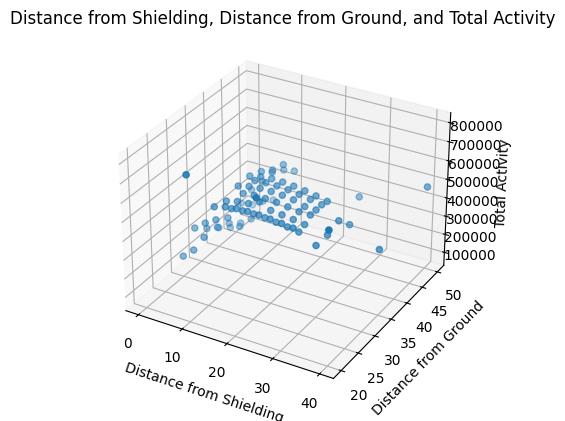

In [12]:
# 3d plot of distance from shielding, distance from ground, and total activity
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trials['distance_from_shielding'], trials['distance_from_ground'], trials['activity'])
ax.set_xlabel('Distance from Shielding')
ax.set_ylabel('Distance from Ground')
ax.set_zlabel('Total Activity')
plt.title('Distance from Shielding, Distance from Ground, and Total Activity')
plt.show()

In [30]:
trials.name.loc[trials['activity'].idxmax()]

'detector_x_50_z_-17'

In [42]:
# 3d plot i can interact with
import plotly.express as px
fig = px.scatter_3d(trials, x='distance_from_shielding', y='distance_from_ground', z='activity', color='activity', hover_name='name')
# make lower limit for x and y axis 0
fig.update_layout(scene=dict(xaxis=dict(range=[0, None]), yaxis=dict(range=[0, None])))
fig.show()

In [69]:
trials.loc[trials.name.tolist().index('detector_x_40_z_-7')]

name                                          detector_x_40_z_-7
x_pos                                                       40.0
z_pos                                                       -7.0
distance_from_shielding                                      0.0
distance_from_ground                                        30.0
filename                   output/mctal/detector_x_40_z_-7.mctal
activity                                                139509.0
Name: 0, dtype: object

In [44]:
time_labels = ['0 to 5 microsec', '5 to 10 microsec', '10 to 15 microsec', '15 to 20 microsec', '20 to 25 microsec', '25 to 30 microsec', '30 to 35 microsec', '35 to 40 microsec', '40 to 45 microsec', '45 to 50 microsec', '50 to 55 microsec', '55 to 60 microsec', '60 to 65 microsec', '65 to 70 microsec', '70 to 75 microsec', '75 to 80 microsec', '80 to 85 microsec', '85 to 90 microsec', '90 to 95 microsec', '95 to 100 microsec', '100 to 105 microsec', '105 to 110 microsec', '110 to 115 microsec', '115 to 120 microsec', '120 to 125 microsec', '125 to 130 microsec', '130 to 135 microsec', '135 to 140 microsec', '140 to 145 microsec', '145 to 150 microsec']


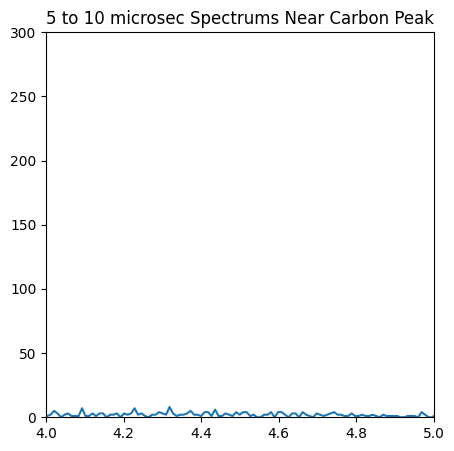

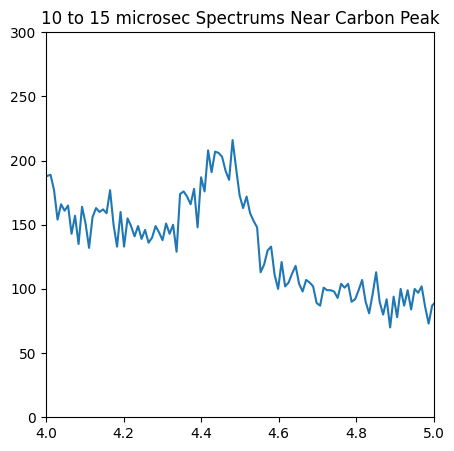

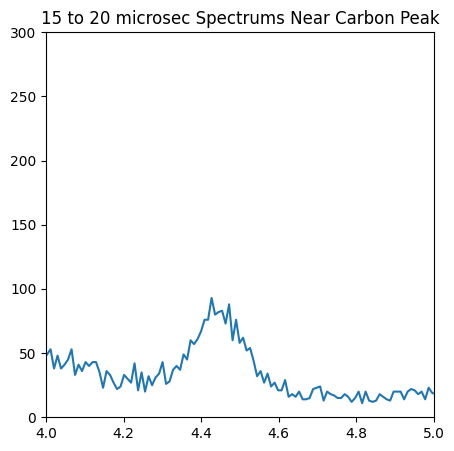

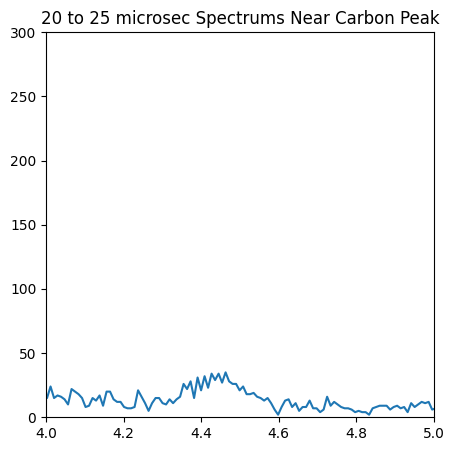

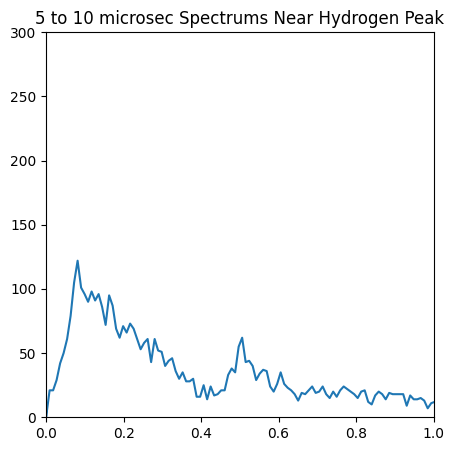

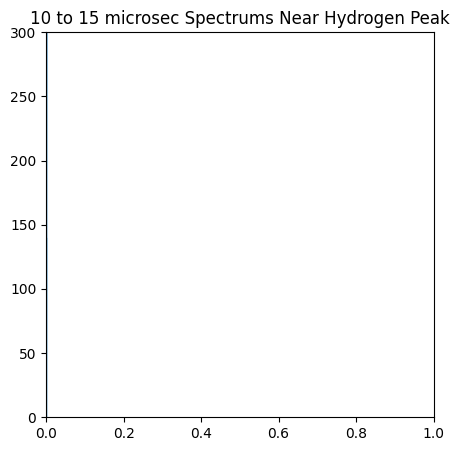

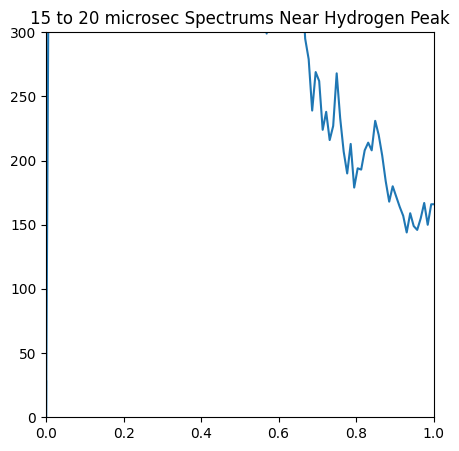

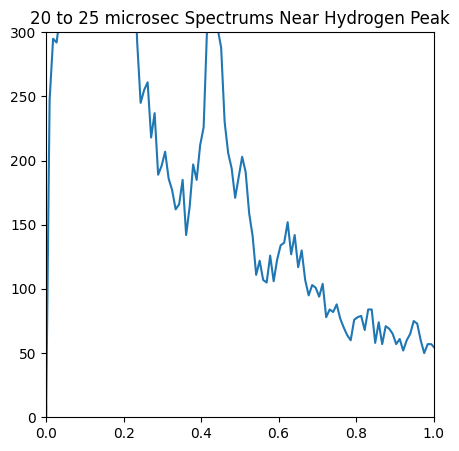

In [71]:
i = trials.name.tolist().index('detector_x_80_z_-17')
for time in range(1, 5):
    plt.figure(figsize=(5, 5))
    plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    plt.xlim(4, 5)
    plt.ylim(0, 300)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums Near Carbon Peak')
    plt.show()

for time in range(1, 5):
    plt.figure(figsize=(5, 5))
    plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 300)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums Near Hydrogen Peak')
    plt.show()

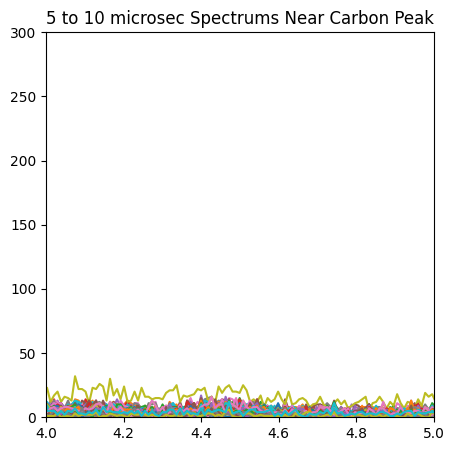

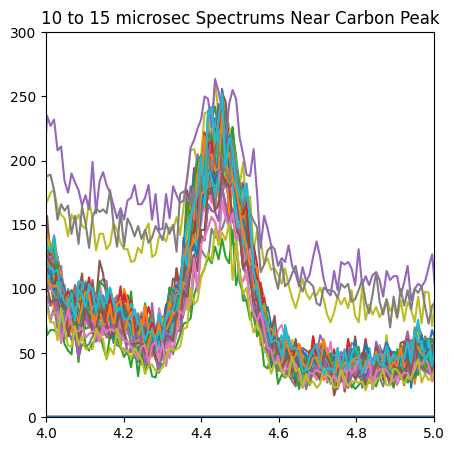

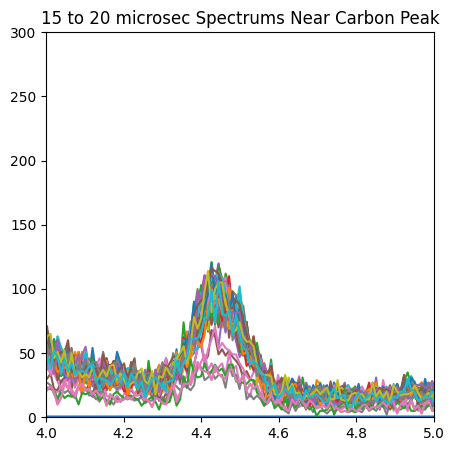

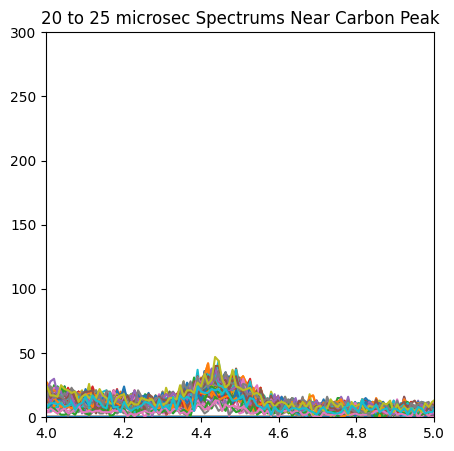

In [15]:
# only plot the first line from each of the spectrograms with bins on the x axis

for time in range(1, 5):
    plt.figure(figsize=(5, 5))
    for i in range(len(spectrograms)):
        plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    plt.xlim(4, 5)
    plt.ylim(0, 300)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums Near Carbon Peak')
    plt.show()

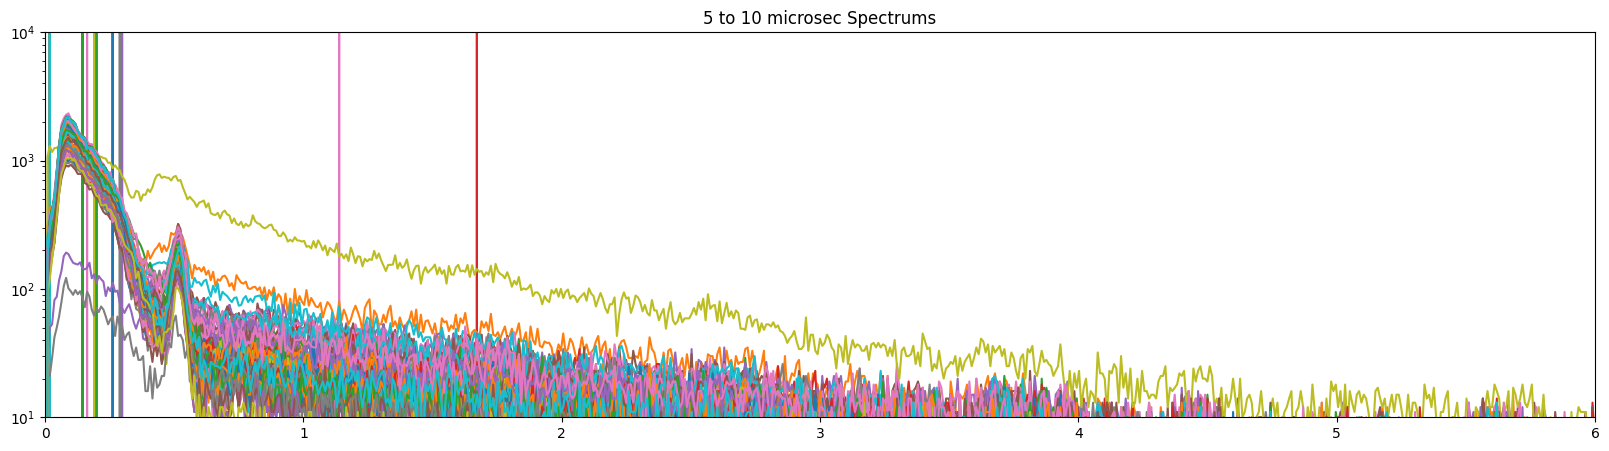

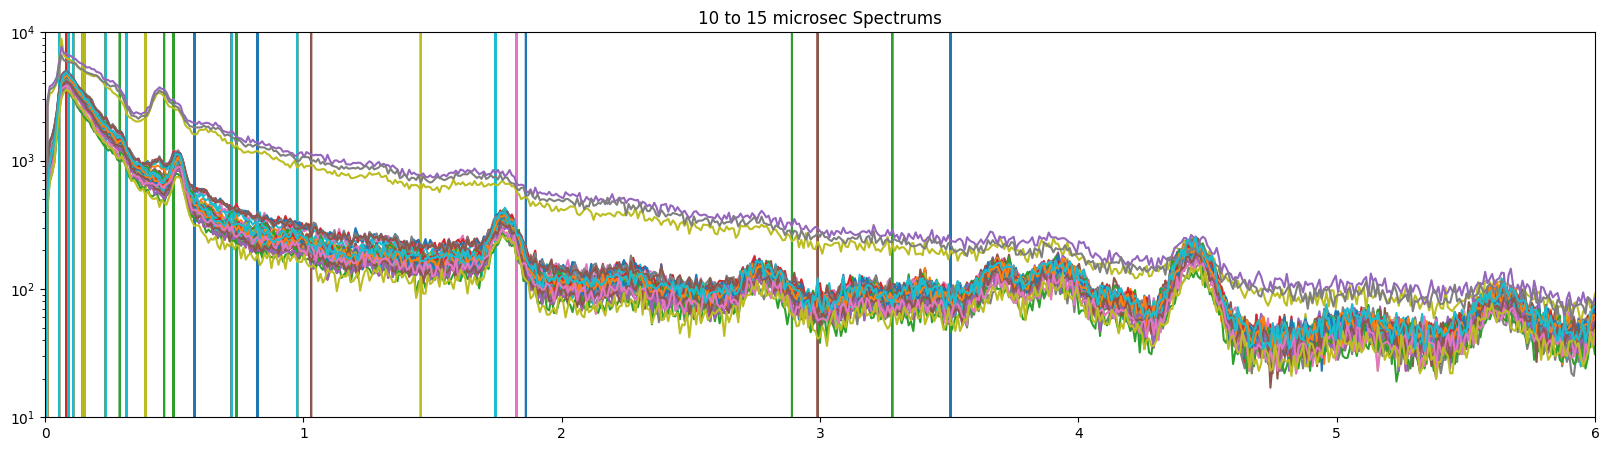

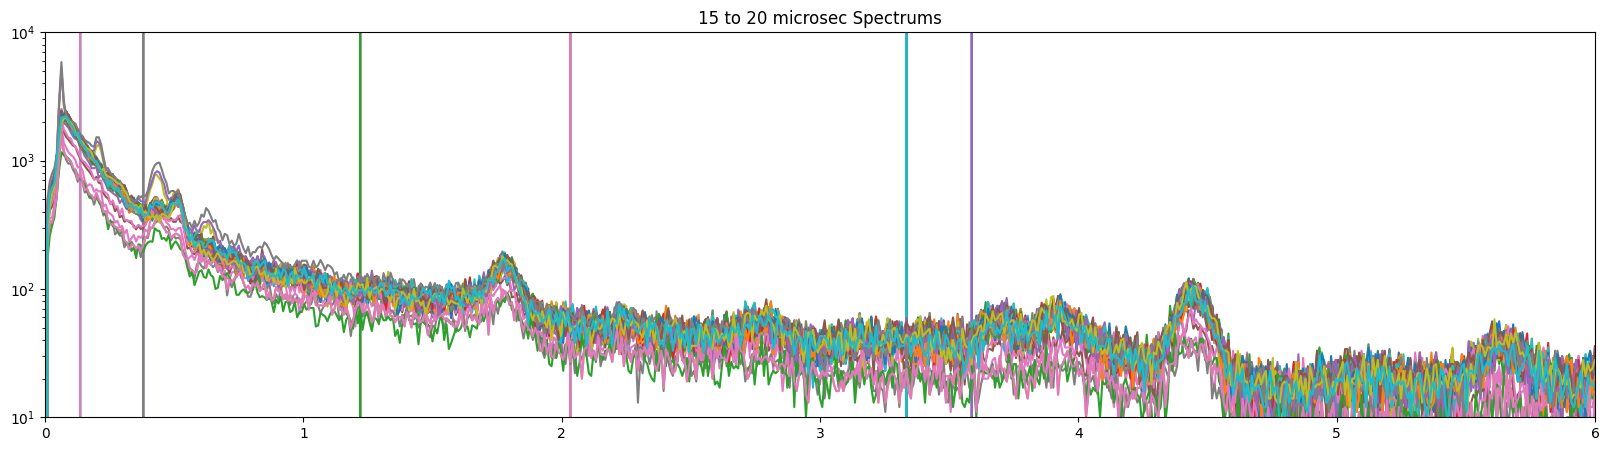

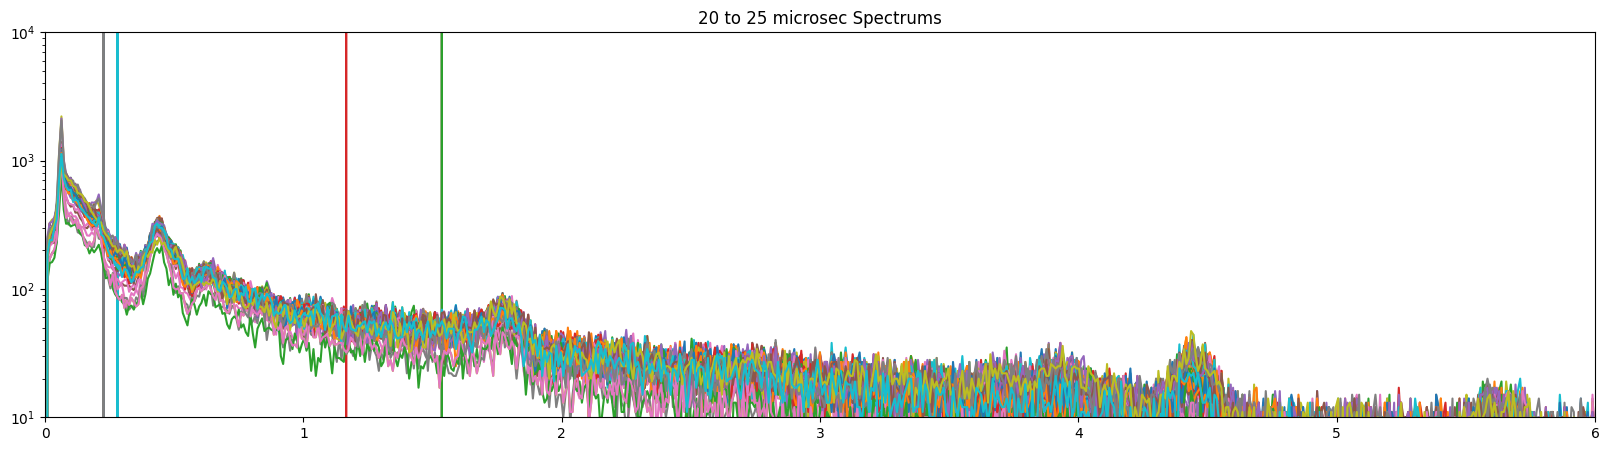

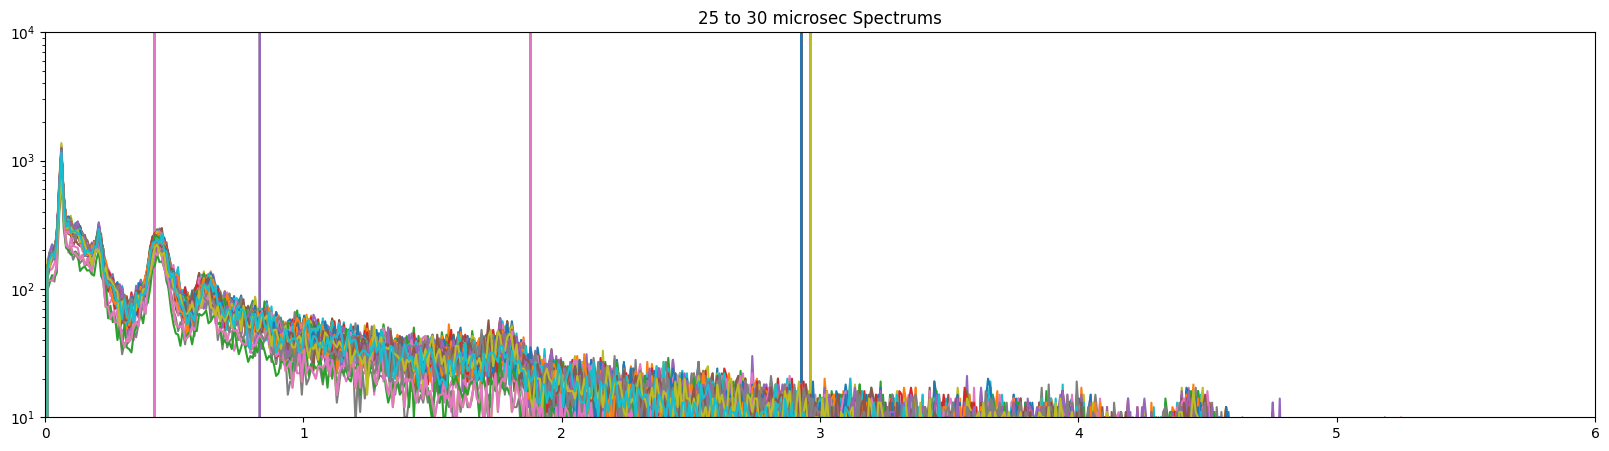

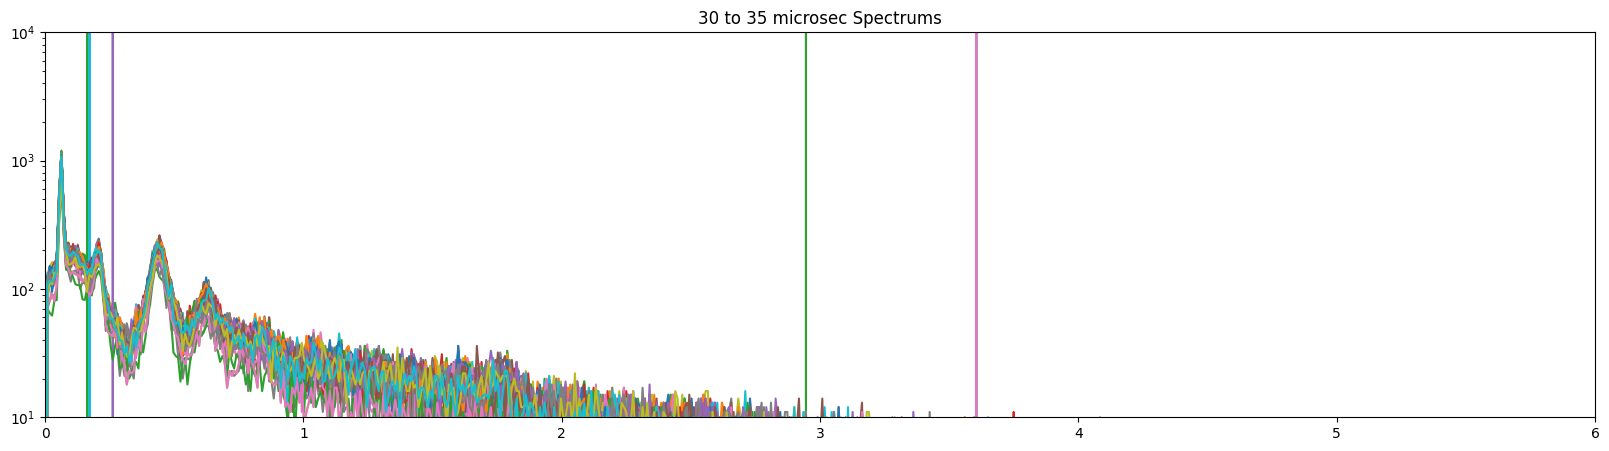

In [16]:
for time in range(1, 7):
    plt.figure(figsize=(20, 5))
    for i in range(len(spectrograms)):
        plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    # plt.xlim(4, 5)
    # plt.ylim(0, 300)
    plt.ylim(1e1, 1e4)
    plt.xlim(0, 6)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums')
    plt.yscale('log')
    plt.show()

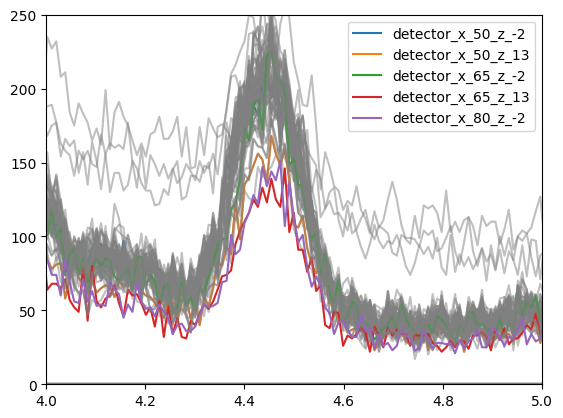

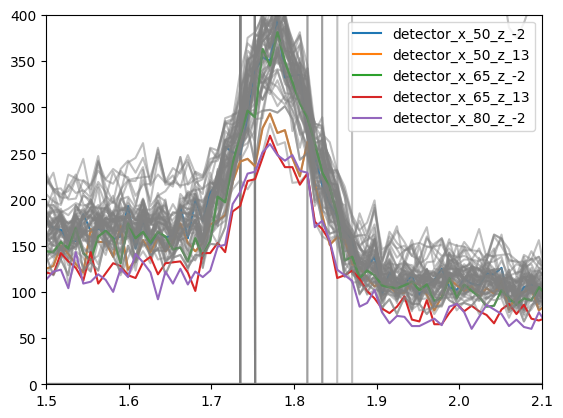

In [17]:
vip1 = [
    # 'detector_x_50_z_-17', 
    'detector_x_50_z_-2', 
    'detector_x_50_z_13', 
    # 'detector_x_65_z_-17', 
    'detector_x_65_z_-2', 
    'detector_x_65_z_13', 
    # 'detector_x_80_z_-17', 
    'detector_x_80_z_-2'
    ]
time = 2
for i in range(len(spectrograms)):
    name = names[i]
    if name in vip1:
        plt.plot(bins, spectrograms[i][time], label=name)
    else:
        plt.plot(bins, spectrograms[i][time], color='gray', alpha=0.5)
plt.legend()
plt.xlim(4, 5)
plt.ylim(0, 250)
plt.show()
for i in range(len(spectrograms)):
    name = names[i]
    if name in vip1:
        plt.plot(bins, spectrograms[i][time], label=name)
    else:
        plt.plot(bins, spectrograms[i][time], color='gray', alpha=0.5)
plt.legend()
plt.xlim(1.5, 2.1)
plt.ylim(0, 400)
plt.show()

In [18]:
spectrums = []
for filename in filenames:
    bins, vals = insd.tools.mcnp_Reader.get_spectrogram(filename, tally=18, start_time_bin=0, end_time_bin=3, nps=1e8)
    
    spectrums.append(np.array(vals))

spectrums = np.array(spectrums)
bins = np.array(bins)

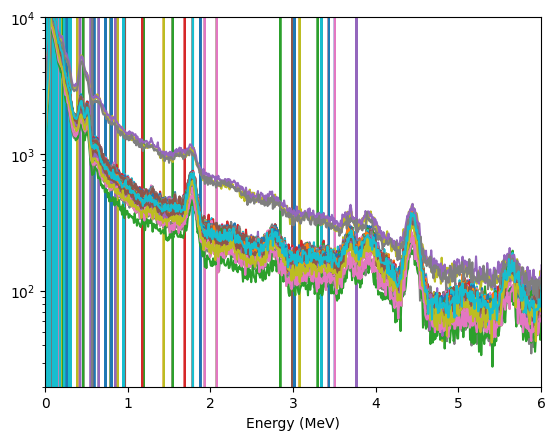

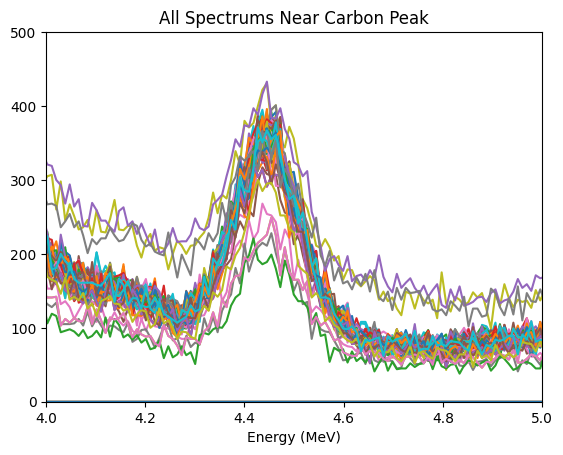

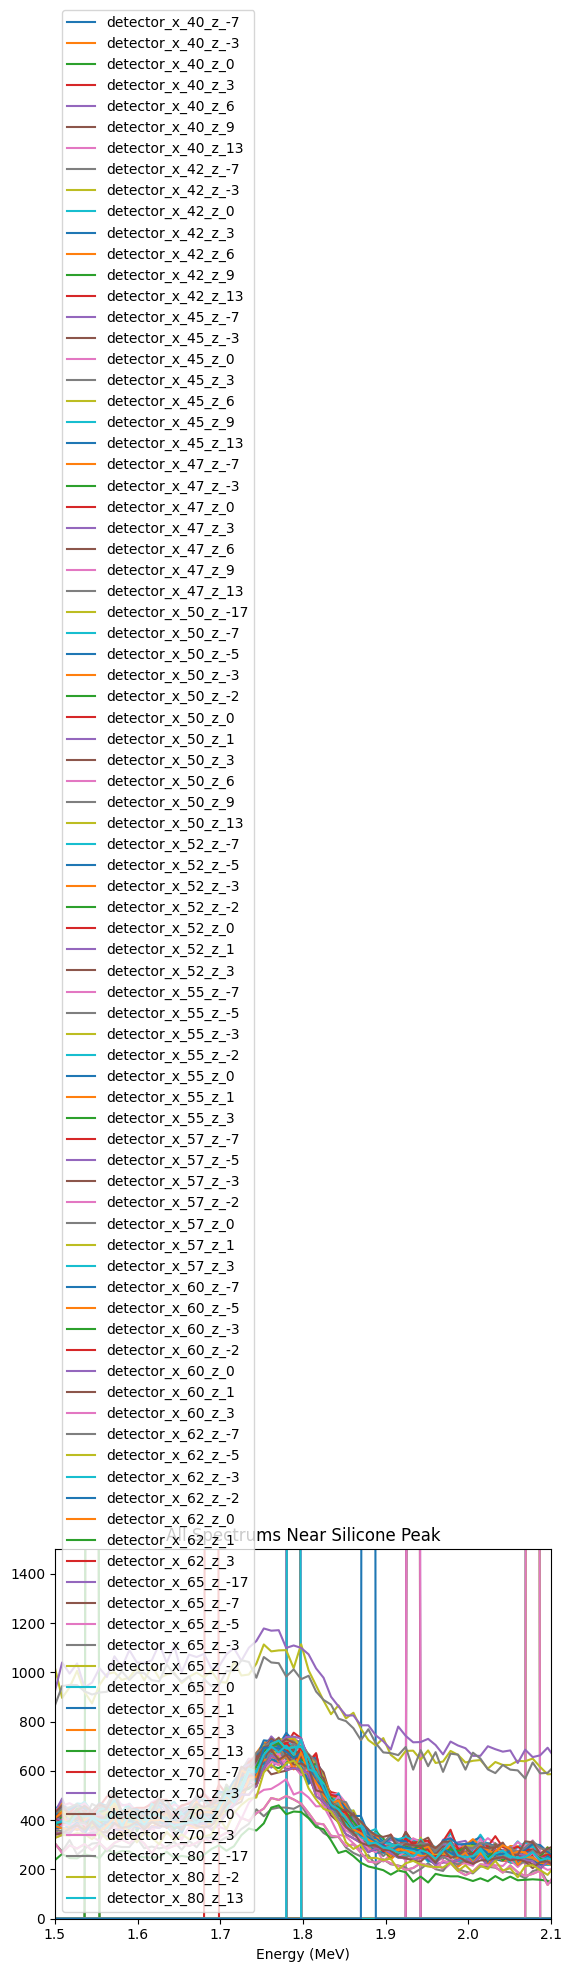

In [49]:
for i in range(len(spectrums)):
    plt.plot(bins, spectrums[i][0], label=names[i])
# plt.legend()
plt.yscale('log')
plt.ylim(2e1, 1e4)
plt.xlim(0, 6)
plt.xlabel('Energy (MeV)')
plt.show()
for i in range(len(spectrums)):
    plt.plot(bins, spectrums[i][0], label=names[i])
# plt.legend()
plt.xlim(4, 5)
plt.ylim(0, 500)
plt.title('All Spectrums Near Carbon Peak')
plt.xlabel('Energy (MeV)')
plt.show()
for i in range(len(spectrums)):
    plt.plot(bins, spectrums[i][0], label=names[i])
# plt.legend()
plt.xlim(1.5, 2.1)
plt.ylim(0, 1500)
plt.title('All Spectrums Near Silicone Peak')
plt.xlabel('Energy (MeV)')
plt.legend()
plt.show()

In [59]:
# bin indexs between 1.5 and 2.1
bins_ = np.array(bins)
find_ = ((bins_ >= 1.5) & (bins_ <= 2.1)).tolist()
ind_start = find_.index(True)
find_ = find_[ind_start:]
ind_end = find_.index(False)+ind_start

In [66]:
outliers = []

for i in range(len(spectrums)):
    if np.all(spectrums[i][0][ind_start:ind_end] < 1400):
        # print(names[i], 'is good')
        pass
    else:
        outliers.append(names[i])
        # print(names[i], 'is bad')

print(outliers)

['detector_x_40_z_-7', 'detector_x_40_z_-3', 'detector_x_40_z_0', 'detector_x_40_z_6', 'detector_x_40_z_9', 'detector_x_40_z_13', 'detector_x_42_z_-7', 'detector_x_42_z_-3', 'detector_x_42_z_0', 'detector_x_42_z_9', 'detector_x_42_z_13', 'detector_x_45_z_-7', 'detector_x_45_z_-3', 'detector_x_45_z_0', 'detector_x_45_z_9', 'detector_x_45_z_13']


In [68]:
trials.loc[trials.name.tolist().index('detector_x_40_z_-7')]

name                                          detector_x_40_z_-7
x_pos                                                       40.0
z_pos                                                       -7.0
distance_from_shielding                                      0.0
distance_from_ground                                        30.0
filename                   output/mctal/detector_x_40_z_-7.mctal
activity                                                139509.0
Name: 0, dtype: object

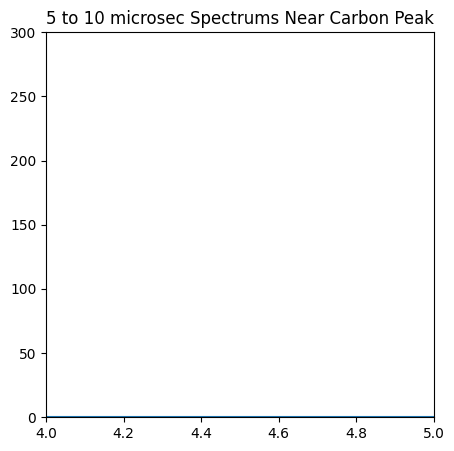

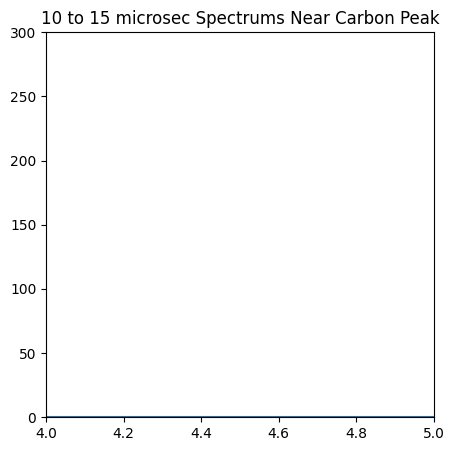

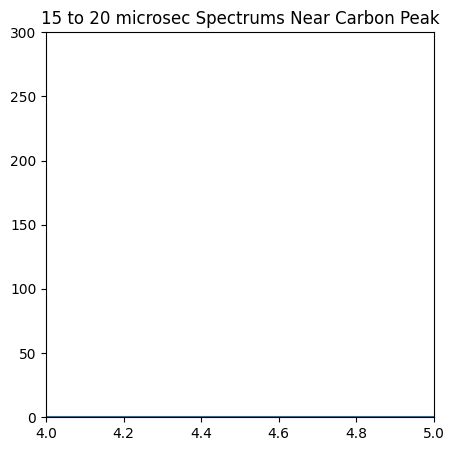

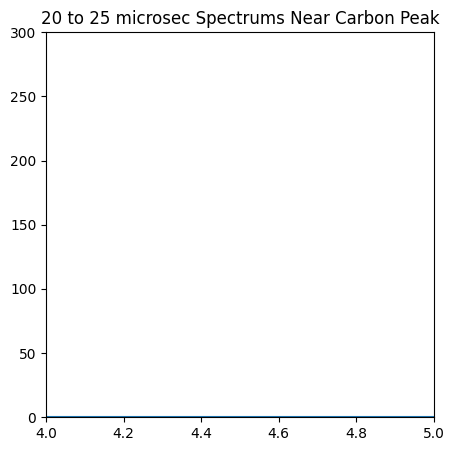

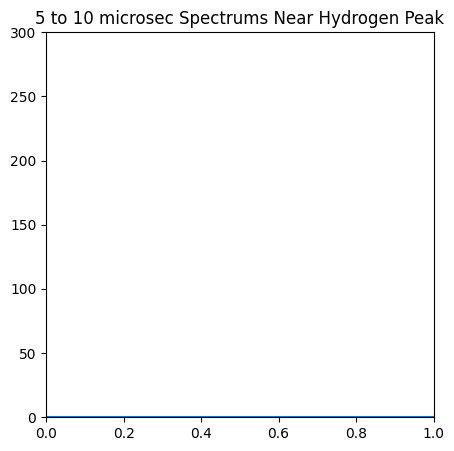

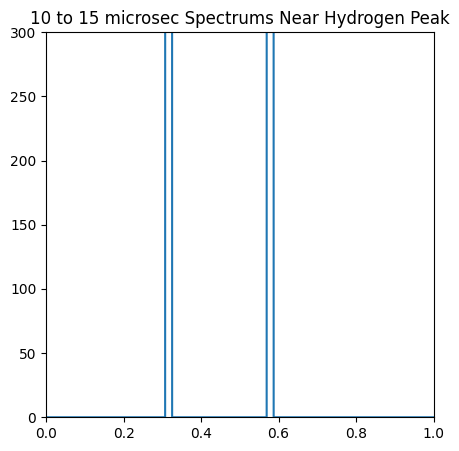

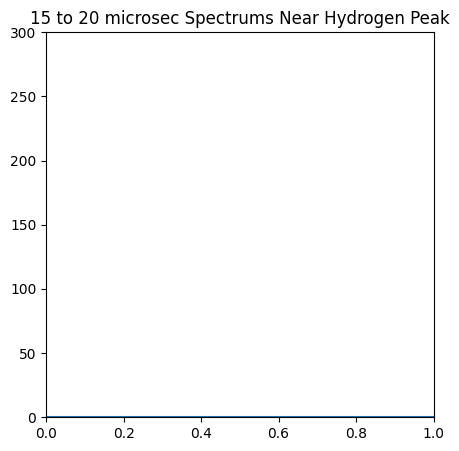

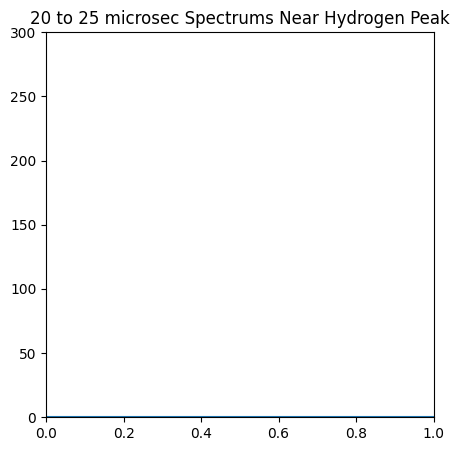

In [67]:
i = trials.name.tolist().index('detector_x_40_z_-7')
for time in range(1, 5):
    plt.figure(figsize=(5, 5))
    plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    plt.xlim(4, 5)
    plt.ylim(0, 300)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums Near Carbon Peak')
    plt.show()

for time in range(1, 5):
    plt.figure(figsize=(5, 5))
    plt.plot(bins, spectrograms[i][time], label=names[i])
    # plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 300)
    time_label = time_labels[time]
    plt.title(time_label+' Spectrums Near Hydrogen Peak')
    plt.show()

In [48]:
proc = insd.proc.Cortes_exp_falloff.main

time = 0
results = []
carbon_integrals = []
silicone_integrals = []

for i in range(len(spectrums)):
    print(i)
    result = proc(bins, spectrums[i][time], return_fits=True)
    results.append(result)
    carbon_integral = result['c']['signal_integral']
    carbon_integrals.append(carbon_integral)
    silicone_integral = result['si']['signal_integral']
    silicone_integrals.append(silicone_integral)


trials['carbon_integral'] = carbon_integrals
trials['silicone_integral'] = silicone_integrals

0


ValueError: Each lower bound must be strictly less than each upper bound.

In [ ]:
# divide the carbon integral by the activity to get the ratio
trials['carbon_activity_ratio'] = trials['carbon_integral'] / trials['activity']
trials['silicone_activity_ratio'] = trials['silicone_integral'] / trials['activity']

In [ ]:
# include word wrap in the column headers
trials[['name', 'x_pos', 'z_pos', 'distance_from_shielding', 'distance_from_ground', 'carbon_integral', 'silicone_integral', 'activity', 'carbon_activity_ratio', 'silicone_activity_ratio']]

name  x_pos      z_pos  distance_from_shielding  \
0  detector_x_50_z_-17   50.0 -17.000000                     10.0   
1   detector_x_50_z_-7   50.0  -7.000000                     10.0   
2   detector_x_50_z_-3   50.0  -3.666667                     10.0   
3   detector_x_50_z_-2   50.0  -2.000000                     10.0   
4    detector_x_50_z_0   50.0  -0.333333                     10.0   
5    detector_x_50_z_3   50.0   3.000000                     10.0   
6   detector_x_50_z_13   50.0  13.000000                     10.0   
7   detector_x_52_z_-7   52.5  -7.000000                     12.5   
8   detector_x_52_z_-3   52.5  -3.666667                     12.5   
9    detector_x_52_z_0   52.5  -0.333333                     12.5   

   distance_from_ground  carbon_integral  silicone_integral  activity  \
0             20.000000        41.010544          35.886300  800397.0   
1             30.000000        44.431011          39.800941  477981.0   
2             33.333333        50.936077          44.533873  453696.0   
3             35.000000        50.867551          44.766605  470293.0   
4             36.666667        53.531592          43.461809  482899.0   
5             40.000000        53.531592          43.461809  482899.0   
6             50.000000        23.875788          28.120593  361253.0   
7             30.000000        48.654271          42.733943  486141.0   
8             33.333333        49.357446          45.144803  460020.0   
9             36.666667        52.241986          50.488875  489267.0   

   carbon_activity_ratio  silicone_activity_ratio  
0               0.000051                 0.000045  
1               0.000093                 0.000083  
2               0.000112                 0.000098  
3               0.000108                 0.000095  
4               0.000111                 0.000090  
5               0.000111                 0.000090  
6               0.000066                 0.000078  
7               0.000100                 0.000088  
8               0.000107                 0.000098  
9               0.000107                 0.000103

In [ ]:
import seaborn as sns

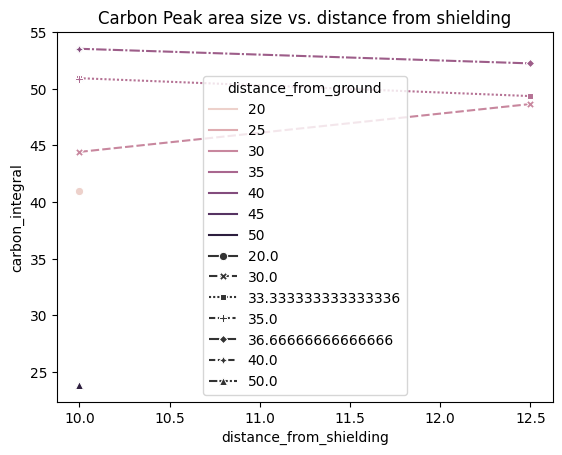

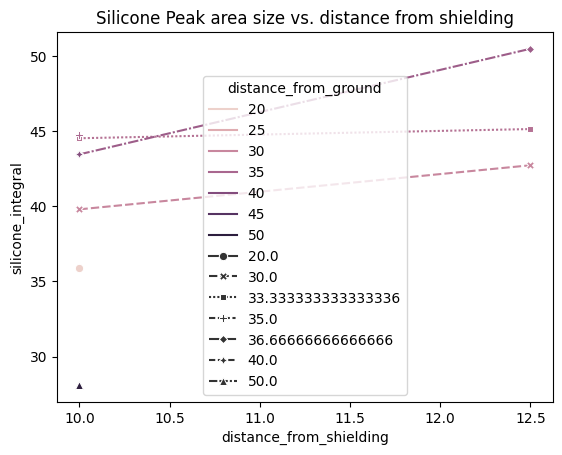

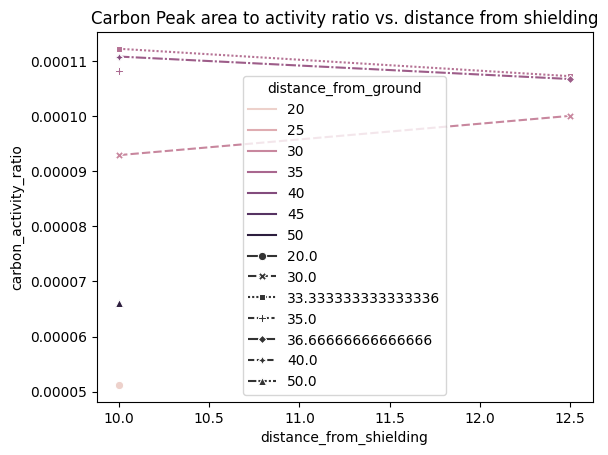

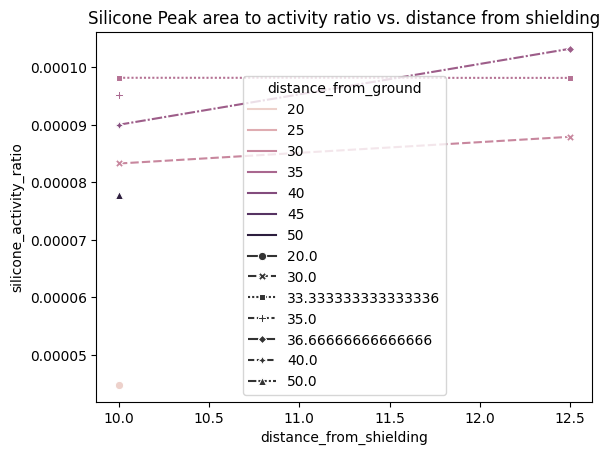

In [ ]:
# using seaborn to plot the data
# graph the carbon integrals as a function of the x position
# label by z position

sns.lineplot(data=trials, x='distance_from_shielding', y='carbon_integral', hue='distance_from_ground', markers=True, style='distance_from_ground')
plt.title('Carbon Peak area size vs. distance from shielding')
plt.show()

# graph the silicone integrals as a function of the x position
# label by z position

sns.lineplot(data=trials, x='distance_from_shielding', y='silicone_integral', hue='distance_from_ground', markers=True, style='distance_from_ground')
plt.title('Silicone Peak area size vs. distance from shielding')
plt.show()

# plot the ratio of the carbon integral to the activity

sns.lineplot(data=trials, x='distance_from_shielding', y='carbon_activity_ratio', hue='distance_from_ground', markers=True, style='distance_from_ground')
plt.title('Carbon Peak area to activity ratio vs. distance from shielding')
plt.show()

# plot the ratio of the silicone integral to the activity

sns.lineplot(data=trials, x='distance_from_shielding', y='silicone_activity_ratio', hue='distance_from_ground', markers=True, style='distance_from_ground')
plt.title('Silicone Peak area to activity ratio vs. distance from shielding')
plt.show()

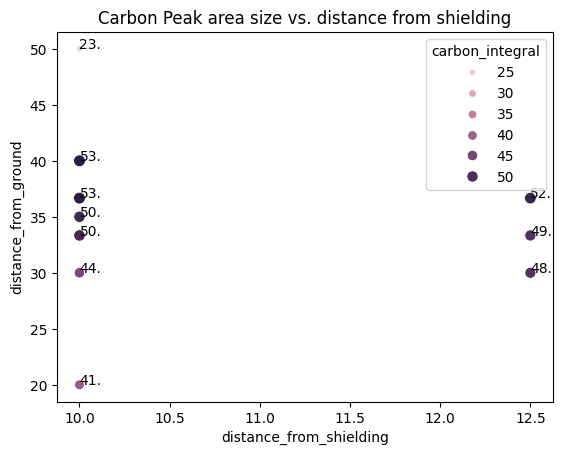

In [ ]:
sns.scatterplot(data=trials, x='distance_from_shielding', y='distance_from_ground', hue='carbon_integral', markers=True, size='carbon_integral')
plt.title('Carbon Peak area size vs. distance from shielding')
for i in range(len(trials)):
    plt.text(trials['distance_from_shielding'][i], trials['distance_from_ground'][i], str(trials['carbon_integral'][i])[:3])
plt.show()

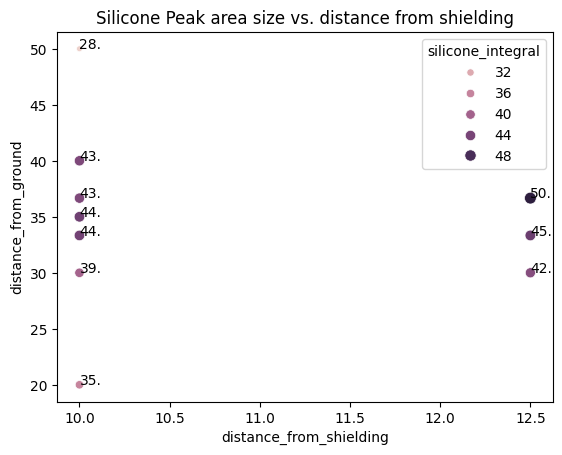

In [ ]:
sns.scatterplot(data=trials, x='distance_from_shielding', y='distance_from_ground', hue='silicone_integral', markers=True, size='silicone_integral')
plt.title('Silicone Peak area size vs. distance from shielding')
# put integral on the points
for i in range(len(trials)):
    plt.text(trials['distance_from_shielding'][i], trials['distance_from_ground'][i], str(trials['silicone_integral'][i])[:3])
# plt.ylim(26, 44)
plt.show()

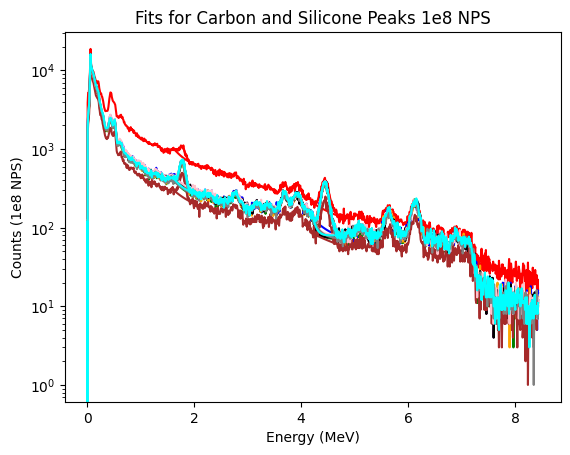

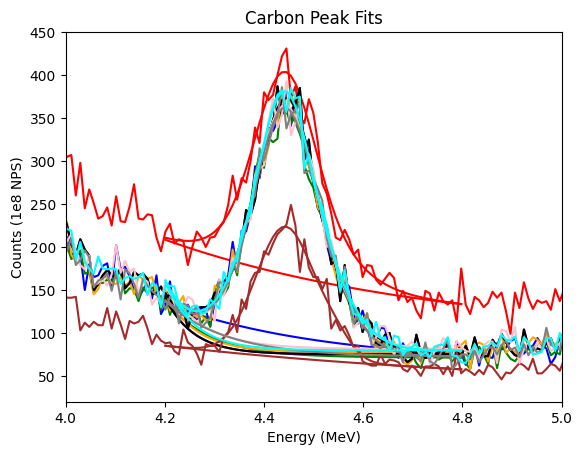

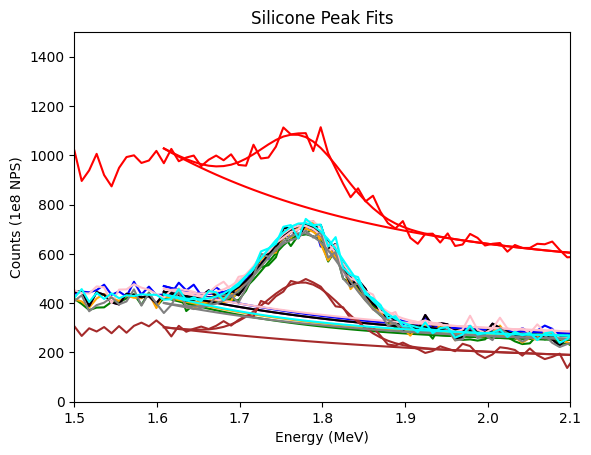

In [ ]:

colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'brown', 'pink', 'gray', 'cyan']

plt.figure()
for i, result in enumerate(results):
    c_fit = result['c']['total_fit']
    c_baseline = result['c']['baseline_fit']
    c_bins = result['c']['bins']
    si_fit = result['si']['total_fit']
    si_baseline = result['si']['baseline_fit']
    si_bins = result['si']['bins']

    name = names[i]
    color = colors[i % len(colors)]
    plt.plot(bins, spectrums[i][time], label=name, color=color)
    plt.plot(c_bins, c_fit, color=color)
    plt.plot(c_bins, c_baseline, color=color)
    plt.plot(si_bins, si_fit, color=color)
    plt.plot(si_bins, si_baseline, color=color)

# plt.legend()
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.title('Fits for Carbon and Silicone Peaks 1e8 NPS')
plt.ylabel('Counts (1e8 NPS)')
plt.show()

plt.figure()

for i, result in enumerate(results):
    c_fit = result['c']['total_fit']
    c_bins = result['c']['bins']
    c_baseline = result['c']['baseline_fit']
    si_fit = result['si']['total_fit']
    si_bins = result['si']['bins']
    si_baseline = result['si']['baseline_fit']

    name = names[i]
    color = colors[i % len(colors)]
    plt.plot(bins, spectrums[i][time], label=name, color=color)
    plt.plot(c_bins, c_fit, color=color)
    plt.plot(c_bins, c_baseline, color=color)
    plt.plot(si_bins, si_fit, color=color)
    plt.plot(si_bins, si_baseline, color=color)

plt.xlim(4, 5)
plt.ylim(20, 450)
# plt.legend()
plt.title('Carbon Peak Fits')
plt.ylabel('Counts (1e8 NPS)')
plt.xlabel('Energy (MeV)')

plt.show()

plt.figure()

for i, result in enumerate(results):
    c_fit = result['c']['total_fit']
    c_bins = result['c']['bins']
    c_baseline = result['c']['baseline_fit']
    si_fit = result['si']['total_fit']
    si_bins = result['si']['bins']
    si_baseline = result['si']['baseline_fit']

    name = names[i]
    color = colors[i % len(colors)]
    plt.plot(bins, spectrums[i][time], label=name, color=color)
    plt.plot(c_bins, c_fit, color=color)
    plt.plot(c_bins, c_baseline, color=color)
    plt.plot(si_bins, si_fit, color=color)
    plt.plot(si_bins, si_baseline, color=color)

plt.xlim(1.5, 2.1)
plt.ylim(0, 1500)
# plt.legend()
plt.title('Silicone Peak Fits')
plt.ylabel('Counts (1e8 NPS)')
plt.xlabel('Energy (MeV)')

plt.show()

In [ ]:
gebless_spectrums = []
for filename in filenames:
    bins, vals = insd.tools.mcnp_Reader.get_spectrogram(filename, tally=68, start_time_bin=0, end_time_bin=1, nps=1e8)
    
    gebless_spectrums.append(np.array(vals))

gebless_spectrums = np.array(gebless_spectrums)
bins = np.array(bins)

In [ ]:
gebless_spectrums.shape

(10, 1, 935)

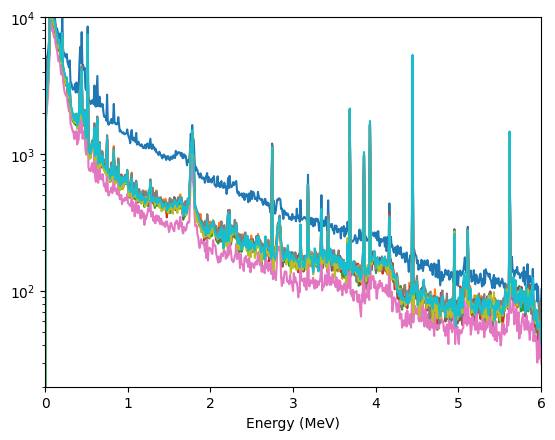

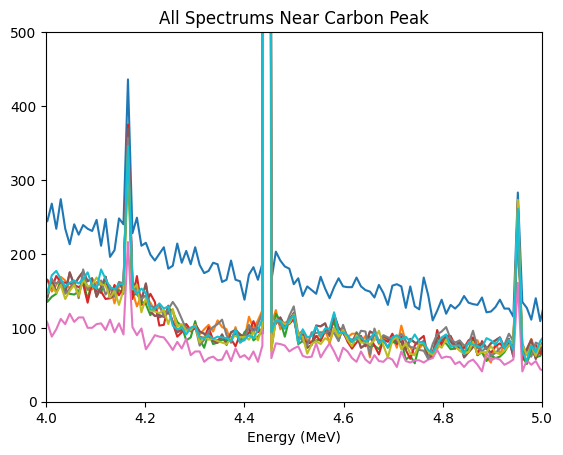

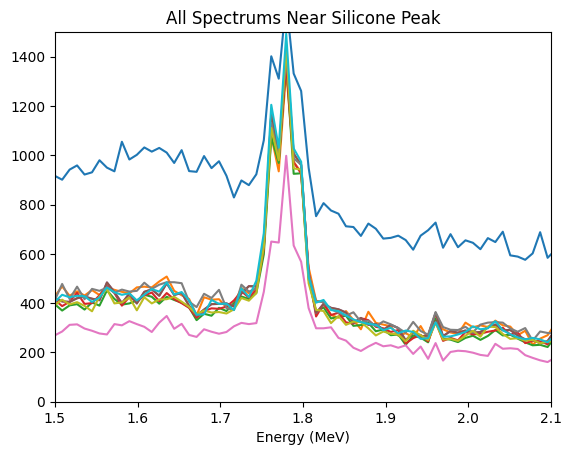

In [ ]:
for i in range(len(gebless_spectrums)):
    plt.plot(bins, gebless_spectrums[i][0], label=names[i])
# plt.legend()
plt.yscale('log')
plt.ylim(2e1, 1e4)
plt.xlim(0, 6)
plt.xlabel('Energy (MeV)')
plt.show()
for i in range(len(gebless_spectrums)):
    plt.plot(bins, gebless_spectrums[i][0], label=names[i])
# plt.legend()
plt.xlim(4, 5)
plt.ylim(0, 500)
plt.title('All Spectrums Near Carbon Peak')
plt.xlabel('Energy (MeV)')
plt.show()
for i in range(len(gebless_spectrums)):
    plt.plot(bins, gebless_spectrums[i][0], label=names[i])
# plt.legend()
plt.xlim(1.5, 2.1)
plt.ylim(0, 1500)
plt.title('All Spectrums Near Silicone Peak')
plt.xlabel('Energy (MeV)')
plt.show()